In [1]:
import pandas as PD
import numpy as NP

kongz_transaction = PD.read_csv('kongz_transaction.csv')

reserve_columns = ['transactionHash', 'blockTimestamp', 'assetId', 'project', 'nftAddress', 'nftTicker', 'usdPrice', 'totalDecimalPrice', 'feeUSDPrice', 'feeTotalDecimalPrice', 'saleType', 'buyer', 'seller', 'meta']
demo_transaction = kongz_transaction[reserve_columns]

In [2]:
# 时间跨度
time_range = demo_transaction['blockTimestamp'].values
time_begin = NP.min(time_range)
time_end = NP.max(time_range)
print('time_begin', time_begin)
print('time_end', time_end)

time_begin 2021-04-17T13:16:20.000Z
time_end 2021-10-19T07:48:06.000Z


In [3]:
# 有效记录
print('total records', len(demo_transaction))

total records 26993


In [4]:
# 价格跨度
price_range = demo_transaction['usdPrice'].values
price_low = NP.min(price_range)
price_high = NP.max(price_range)
print('Minimal price', price_low)
print('Maximal price', price_high)

Minimal price 2.0123e-08
Maximal price 746257.45845


In [5]:
token_group = demo_transaction.groupby('assetId')
print('different groups', len(token_group))
# print('details', list(token_group)[: 2]) # 预览

different groups 11590


In [6]:
# 每组的数量，价格的分位数，均值等基本统计量
token_info = token_group.agg({'usdPrice': ['min', 'mean', 'max', 'var', 'count']})
token_info.columns = ['price_min', 'price_mean', 'price_max', 'price_var', 'count']
token_info.head(10)

,price_min,price_mean,price_max,price_var,count
assetId,,,,,
1,196420.800000,226416.231726,256411.663451,1.799452e+09,2
2,20398.500000,20398.500000,20398.500000,NaN,1
6,395526.400000,395526.400000,395526.400000,NaN,1
9,5341.000000,5341.000000,5341.000000,NaN,1
11,5.745780,68603.446890,137201.148000,6.274193e+09,4
14,3155.912045,53010.810111,123990.568288,3.984948e+09,3
16,2279.537410,31365.409489,60451.281568,1.691976e+09,2
17,5975.381000,6313.695400,6652.009800,2.289133e+05,2
23,288069.725500,288069.725500,288069.725500,NaN,1


In [7]:
# 交易频次统计
counters = token_info['count'].values
set(counters)
counter_set = list(set(counters))
freq_set = []
for single_counter in counter_set:
    freq_set.append(len(NP.where(counters == single_counter)[0]))
summary = PD.DataFrame({
    'counter': counter_set,
    'freq': freq_set
})
print(summary)

    counter  freq
0         1  3506
1         2  3976
2         3  2224
3         4  1103
4         5   447
5         6   198
6         7    88
7         8    29
8         9    14
9        10     2
10       11     2
11       12     1


In [8]:
from matplotlib import pyplot as plt
# 交易数量概览
plt.hist(token_info['count'].values, bins=10, density=True)
plt.title("Distribution of Transaction counts")

Text(0.5, 1.0, 'Distribution of Transaction counts')

Text(0.5, 1.0, 'Price Variance')

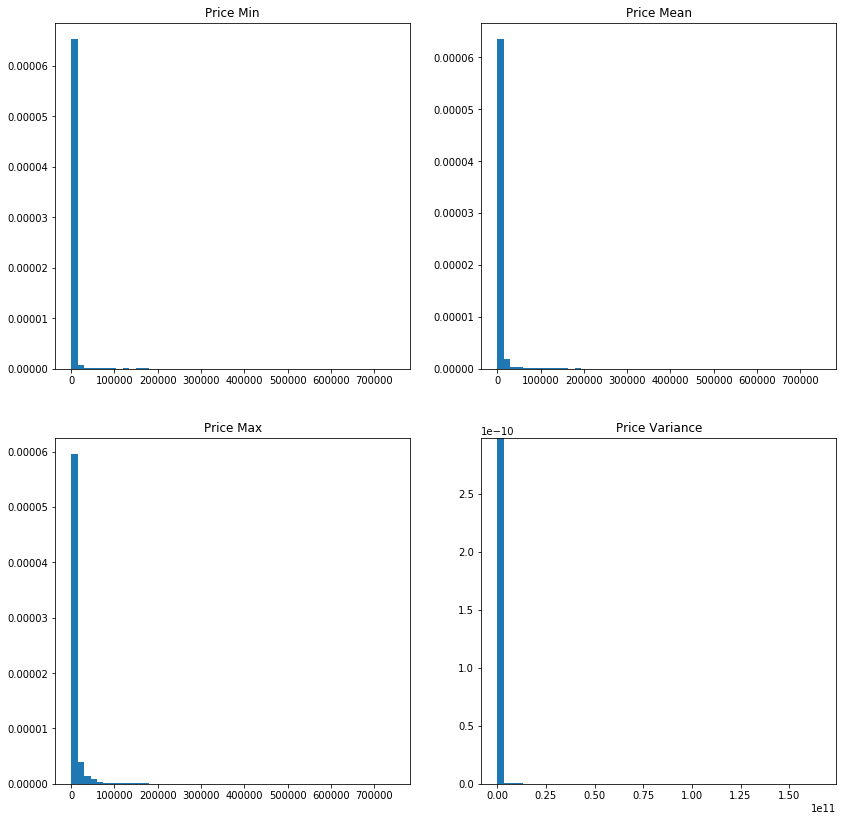

In [9]:
# 价格分布
plt.figure(figsize=(14, 14))
plt.subplot(2, 2, 1)
plt.hist(token_info['price_min'].values, bins=50, density=True)
plt.title("Price Min")
plt.subplot(2, 2, 2)
plt.hist(token_info['price_mean'].values, bins=50, density=True)
plt.title("Price Mean")
plt.subplot(2, 2, 3)
plt.hist(token_info['price_max'].values, bins=50, density=True)
plt.title("Price Max")
plt.subplot(2, 2, 4)
plt.hist(token_info['price_var'].values, bins=50, density=True)
plt.title("Price Variance")

In [10]:
# 以10为步长计算累计概率分布
def cumulative_function(value_list: NP.ndarray) -> PD.DataFrame:
    # value_list = token_info['price_min'].values
    value_max = max(value_list)
    value_axis, prob_axis = [], []
    cursor = 0
    while cursor < value_max:
        value_axis.append(cursor)
        prob_axis.append(len(NP.where(value_list < cursor)[0]) / len(value_list))
        cursor += 10
    return PD.DataFrame({
        'value': value_axis,
        'prob': prob_axis
    })

Text(0.5, 1.0, 'CDF of price max')

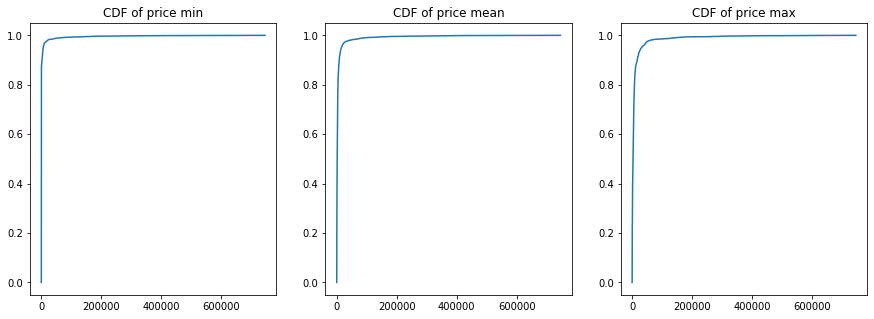

In [11]:
# 计算最低价、平均价、最高价的累计概率密度函数
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
price_min_cdf = cumulative_function(token_info['price_min'].values)
plt.plot(price_min_cdf['value'], price_min_cdf['prob'])
plt.title("CDF of price min")

plt.subplot(1, 3, 2)
price_mean_cdf = cumulative_function(token_info['price_mean'].values)
plt.plot(price_mean_cdf['value'], price_mean_cdf['prob'])
plt.title("CDF of price mean")

plt.subplot(1, 3, 3)
price_max_cdf = cumulative_function(token_info['price_max'].values)
plt.plot(price_max_cdf['value'], price_max_cdf['prob'])
plt.title("CDF of price max")

In [12]:
def cal_quantile_threshold(cdf_results: PD.DataFrame) -> PD.DataFrame:
    quantile_options = range(1, 19)
    quantile_text = [str(_ * 5) +'%' for _ in quantile_options]
    value_collection = []
    for quantile_option in quantile_options:
        left_values = cdf_results.loc[cdf_results['prob'] < quantile_option / 20]
        value_collection.append(left_values['value'].values[-1])
    return PD.DataFrame({
        'quantile': quantile_text,
        'value': value_collection
    })

In [13]:
min_indicator = cal_quantile_threshold(price_min_cdf)
mean_indicator = cal_quantile_threshold(price_min_cdf)
max_indicator = cal_quantile_threshold(price_max_cdf)
compare = PD.DataFrame({
    'quantile': min_indicator['quantile'].values,
    'min': min_indicator['value'].values,
    'mean': mean_indicator['value'].values,
    'max': max_indicator['value'].values
})
print("Quantile of Price\n")
print(compare)

Quantile of Price

   quantile   min  mean    max
0        5%   220   220    220
1       10%   220   220    220
2       15%   220   220    220
3       20%   220   220    220
4       25%   220   220   1050
5       30%   220   220   1180
6       35%   220   220   1400
7       40%   220   220   1860
8       45%   220   220   2550
9       50%   220   220   3130
10      55%   220   220   3460
11      60%   220   220   4060
12      65%   220   220   4550
13      70%   220   220   5430
14      75%   220   220   6650
15      80%   220   220   7970
16      85%   220   220   9850
17      90%  2650  2650  16860


In [14]:
PD.options.display.max_columns = None
PD.options.display.max_rows = None
price_min_cdf.iloc[20: 25, :]

,value,prob
20,200,0.016048
21,210,0.016393
22,220,0.016825
23,230,0.869025
24,240,0.869025


In [15]:
# 选出交易最高的查看明细
specific_info = token_info[token_info['count'] == 12]
specific_token_id = specific_info.index[0]
specific_records = demo_transaction.loc[demo_transaction['assetId'] == specific_token_id].reset_index(drop=True)
specific_records = specific_records[['blockTimestamp', 'usdPrice', 'buyer', 'seller']]
print(specific_records)

              blockTimestamp     usdPrice  \
0   2021-08-21T03:33:09.000Z  8810.170255   
1   2021-08-19T04:07:56.000Z  1491.931917   
2   2021-08-15T19:34:24.000Z  1112.189547   
3   2021-08-15T19:11:26.000Z   222.437909   
4   2021-07-31T18:11:20.000Z  1598.887832   
5   2021-07-28T02:20:09.000Z  1389.638257   
6   2021-07-27T17:24:19.000Z  1309.896784   
7   2021-07-27T17:13:03.000Z     2.797200   
8   2021-07-27T00:55:47.000Z  1392.018750   
9   2021-07-24T05:31:55.000Z   850.292000   
10  2021-07-11T23:18:20.000Z   579.746700   
11  2021-07-10T08:42:29.000Z   505.920278   

                                         buyer  \
0   0x12bcf162bcaab6c6f829dcaa5026d72af956864c   
1   0xe59191faf2663605c5fecdbf71be18deac3d13ee   
2   0x7db7f636eb50ab2734b587a4eb0ee3e8e75d5254   
3   0x41246a417c123ec0da4eaef2f309fe1796e7e69d   
4   0x6e7ae8dee2f39eb521cca1762e0dadfccd2e88b2   
5   0xe58deef4b6c17f614a12298f176db39ec5e2a521   
6   0x9d59eba4deaee09466ba9d4073bf912bc72982b0   
7   0xfa6c54de

In [16]:
# 另一组
specific_info = token_info[token_info['count'] == 11]
specific_token_id = specific_info.index[1]
specific_records = demo_transaction.loc[demo_transaction['assetId'] == specific_token_id].reset_index(drop=True)
specific_records = specific_records[['blockTimestamp', 'usdPrice', 'buyer', 'seller']]
print(specific_records)

              blockTimestamp     usdPrice  \
0   2021-10-12T09:29:10.000Z  5842.611900   
1   2021-10-07T07:51:08.000Z  7183.116900   
2   2021-10-06T12:53:18.000Z  8574.840450   
3   2021-09-19T06:53:17.000Z  6150.822563   
4   2021-09-11T09:05:33.000Z  4652.253088   
5   2021-09-04T07:01:15.000Z  5717.393215   
6   2021-09-01T05:58:09.000Z  2973.182746   
7   2021-08-28T12:32:00.000Z  2647.026419   
8   2021-08-19T22:11:07.000Z  1501.215010   
9   2021-08-15T21:04:33.000Z  1075.657935   
10  2021-08-15T19:06:00.000Z   222.437909   

                                         buyer  \
0   0x87c241ab2c898d455dfdb725d1717553ac6eeae3   
1   0xc34f37006cb57957b5296e9d7cd4f71958ec0b8f   
2   0x6009303f26c0101022cb68d6cb95d46a8f6100a3   
3   0xfb72f7123f0924f9e2d9544d9b2b778a33a94ea5   
4   0xef97c92c47a76756cf8f33fb8b227cd8ebd7638d   
5   0x871bf04e39e5134da87fff8dca6b7923e01b8004   
6   0x759edbda766e33a3a02279a0708c8e9ec96de723   
7   0x6789c80dce206a1438ed3f1f082723615bc888bd   
8   0xdd2

In [17]:
specific_info = token_info[token_info['count'] == 10]
specific_token_id = specific_info.index[0]
specific_records = demo_transaction.loc[demo_transaction['assetId'] == specific_token_id].reset_index(drop=True)
specific_records = specific_records[['blockTimestamp', 'usdPrice', 'buyer', 'seller']]
print(specific_records)

             blockTimestamp     usdPrice  \
0  2021-09-10T04:51:05.000Z  8977.961400   
1  2021-09-07T00:17:09.000Z  9793.618200   
2  2021-08-25T05:03:51.000Z  6584.628959   
3  2021-08-24T06:31:09.000Z  7629.675856   
4  2021-08-20T13:44:26.000Z  5635.550820   
5  2021-08-20T11:27:23.000Z  3209.842854   
6  2021-08-20T05:59:34.000Z  6280.774003   
7  2021-08-19T20:30:02.000Z  9343.966514   
8  2021-08-15T19:13:45.000Z   222.437909   
9  2021-05-30T15:05:19.000Z   224.041350   

                                        buyer  \
0  0x583ae442a93b098bbc0556a5e4d892c66aea6b47   
1  0x527d968af4283f20924c2e5b8dff867aab566478   
2  0x9d59eba4deaee09466ba9d4073bf912bc72982b0   
3  0xd14ab59a934a22b072f331453c205f85c168aae4   
4  0xb5696e4057b9ba76616cecb5a537eaca7b3cdf54   
5  0xfce0413bad4e59f55946669e678eccfe87777777   
6  0x7417cc585602d8e225b26e395a1efe40ec4a74a9   
7  0xe3061184fef7c293ef41f99cc87252cc8736031a   
8  0xc37cd5e34ef273f6aefe6900fc9d75563cdcfe03   
9  0xf04928ec019e13753aca

In [18]:
# 查看高交易量的NFT有何共性
basic_info = PD.read_csv('kongz_basic_info.csv')
popular_tokens = list(token_info.loc[token_info['count'] >= 9].index)